In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import re
import nltk
import pandas as pd

# retrieve csv data set
dataset = pd.read_csv('/content/gdrive/MyDrive/FinancialSentiments/stockerbot-export1.csv')

CLEAN UP DATASET

In [ ]:
#Remove unnecessary columns in table (ID)
dataset = dataset.drop('id',axis=1)
dataset.isnull().sum()

dataset = dataset.drop('url', axis=1)

In [ ]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def clean_set(dataset):
  clean_tweets = []
  for i in range(0, len(dataset['text'])):
    text = re.sub(r'http\S+', '', dataset.loc[i, 'text'])
    text = text.lower()
    # split into tokens by white space
    tokens = text.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    clean_tweets.append(tokens)
  return clean_tweets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
clean_tweets = clean_set(dataset)

print(clean_tweets)

[['video', 'office', 'minding', 'solomon', 'tells', 'gs', 'interns', 'learned'], ['price', 'lumber', 'lbf', 'since', 'hitting', 'ytd', 'highs', 'macys', 'turnaround', 'still'], ['says', 'american', 'dream', 'dead'], ['barry', 'silbert', 'extremely', 'optimistic', 'bitcoin', 'predicts', 'new', 'crypto', 'entrants'], ['satellites', 'avoid', 'attacks', 'space', 'junk', 'circling', 'earth', 'paid', 'oracle'], ['realmoneys', 'david', 'butlers', 'favorite', 'fang', 'stock', 'isnt', 'realmoneysod', 'alphabet', 'facebook'], ['miss', 'convo', 'one', 'favorite', 'thinkers', 'samharrisorg'], ['us', 'intelligence', 'documents', 'nelson', 'mandela', 'made', 'public'], ['senate', 'wants', 'emergency', 'alerts', 'go', 'netflix', 'spotify', 'etc', 'grg'], ['hedge', 'fund', 'manager', 'marc', 'larsy', 'says', 'bitcoin', 'possible'], ['us', 'proposes', 'expedited', 'appeal', 'fight', 'atampt', 'time', 'warner', 'purchase'], ['roger', 'federers', 'uniqlo', 'deal', 'makes', 'one', 'athletes', 'earn'], ['b

In [ ]:
dataset['clean_tweets'] = clean_tweets

CLASSIFYING TWEET SET AS POSITIVE, NEUTRAL OR NEGATIVE


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
nltk.download('vader_lexicon')


analyzer = SentimentIntensityAnalyzer()

def findpolarity(data):
    polarity = analyzer.polarity_scores(data)
    if(polarity['compound'] >= 0):
        sentiment = 1
    if(polarity['compound'] < 0):
        sentiment = -1
    return(sentiment)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sentiment = []
for i in range(0, len(clean_tweets)):
    body = ' '.join(dataset.loc[i, 'clean_tweets'])
    s = findpolarity(body)
    sentiment.append(s)

In [ ]:
tweet_sentiment = pd.DataFrame()
tweet_sentiment['clean_tweets'] = clean_tweets
tweet_sentiment['sentiment'] = sentiment

tweet_sentiment.to_csv('/content/gdrive/MyDrive/FinancialSentiments/tweet_sentiment.csv', index=False)

LET'S SEPARATE NEGATIVE AND POSITIVE WORDS INTO ITS RESPECTIVE SENTIMENTS FILE, negative.txt and positive.txt. Data will be ready for use in a bag-of-words model

In [ ]:
from collections import Counter

vocab = Counter()

#Let's simplify the previous clean_tweet method to receive a string (to be broken)
def clean_token(text):
    text = re.sub(r'http\S+', '', text)
    text = text.lower()
    # split into tokens by white space
    tokens = text.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens;

#gather dataset tweet body and add to vocab
def add_data_to_vocab(dataset):
  for i in range(0, len(dataset['clean_tweets'])):
    body = ' '.join(dataset.loc[i, 'clean_tweets'])
    tokens = clean_token(body)
    vocab.update(tokens)

#add word tokens to vocab
add_data_to_vocab(dataset)
print(len(vocab))
#print top words in the vocab
print(vocab.most_common(50))

18853
[('rt', 4602), ('inc', 3958), ('amp', 2532), ('earnings', 1880), ('stock', 1813), ('price', 1759), ('analysts', 1641), ('eps', 1427), ('us', 1310), ('new', 1186), ('group', 1120), ('expected', 1092), ('binance', 1090), ('stocks', 1047), ('short', 1009), ('register', 985), ('bonus', 959), ('million', 929), ('join', 909), ('buy', 899), ('high', 880), ('today', 865), ('rating', 853), ('co', 851), ('target', 843), ('options', 833), ('trading', 831), ('share', 816), ('shares', 782), ('investment', 779), ('energy', 753), ('get', 737), ('corp', 721), ('zacks', 706), ('top', 692), ('week', 691), ('see', 690), ('nflx', 678), ('research', 677), ('financial', 673), ('corporation', 665), ('maxpain', 632), ('interest', 620), ('sales', 614), ('management', 611), ('trade', 603), ('capital', 582), ('per', 581), ('jul', 568), ('bullish', 567)]


In [ ]:
#Keep tokens with more than 3 occurences
min_occurrence = 3
tokens = [k for k,c in vocab.items() if c >= min_occurrence]
print(len(tokens))

8902


In [ ]:
#save vocabulary list to an export txt file
def save_list(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

save_list(tokens, '/content/gdrive/MyDrive/FinancialSentiments/vocab.txt')

It is time to develop a bag-of-words model for sentiment analysis

In [ ]:
def tweet_to_line(text, vocab):
  #clean input
  tokens = clean_token(text)
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)

#example input
body1 = "Hello, I like to fish! Nice Job yesterday"

print(tweet_to_line(body1,vocab))

tweet_sentiment.head(5)

hello like fish nice job yesterday


,clean_tweets,sentiment
0,"[video, office, minding, solomon, tells, gs, i...",1
1,"[price, lumber, lbf, since, hitting, ytd, high...",1
2,"[says, american, dream, dead]",-1
3,"[barry, silbert, extremely, optimistic, bitcoi...",1
4,"[satellites, avoid, attacks, space, junk, circ...",-1


In [ ]:
from numpy import array

def process_set(dataset, vocab, benchmark, is_train):
  lines = list()
  for i in range(0, len(dataset)):
    score = dataset.loc[i, 'sentiment']
    if (score == benchmark):
      line = ' '.join(dataset.loc[i, 'clean_tweets'])
      clean_line = tweet_to_line(line, vocab)
      if is_train and (i % 5 == 1):
        continue
      if not is_train and not (i % 5 == 1):
        continue;
      lines.append(clean_line)
  return lines

def load_clean_dataset(vocab, is_train):
  #load tweets
  neg_benchmark = -1
  pos_benchmark = 1
  neg = process_set(tweet_sentiment, vocab, neg_benchmark, is_train)
  pos = process_set(tweet_sentiment, vocab, pos_benchmark, is_train)
  docs = neg + pos
  labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
  return docs, labels

In [ ]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r' )
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

#load the vocabulary
vocab_filename = '/content/gdrive/MyDrive/FinancialSentiments/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

print(vocab)

{'akns', 'quest', 'reaffirmed', 'starting', 'plan', 'jt', 'tuesday', 'ignores', 'zuo', 'kep', 'swann', 'god', 'quantbot', 'sya', 'transports', 'fcg', 'hpt', 'rsx', 'intuitivesurgical', 'incyte', 'zts', 'bajas', 'seas', 'closer', 'khak', 'begging', 'glog', 'oa', 'ingn', 'choppy', 'rr', 'roadmap', 'ausbiz', 'rhhby', 'therapeutics', 'valley', 'mallinckrodt', 'version', 'strenght', 'cntf', 'wsm', 'rvt', 'guys', 'bluemountain', 'argentina', 'naj', 'ardr', 'icd', 'long', 'midterm', 'cibr', 'hsr', 'buzz', 'exxon', 'ceo', 'goertek', 'eslt', 'eyes', 'boe', 'valero', 'todas', 'four', 'withrank', 'aws', 'entering', 'subcriptions', 'khc', 'mgo', 'radar', 'gprk', 'dynatronics', 'nvs', 'session', 'era', 'domainmondo', 'sbm', 'set', 'decent', 'alaska', 'underway', 'rckt', 'cheapest', 'prvclo', 'thesis', 'mb', 'meduelesméxico', 'crunch', 'nem', 'ramp', 'luck', 'ym', 'clps', 'vgk', 'giant', 'bbl', 'video', 'arjunpancho', 'tripadvisor', 'brought', 'bxs', 'lending', 'rex', 'agmh', 'worked', 'artemis', 'h

In [ ]:
from keras.preprocessing.text import Tokenizer

# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)

#encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode= 'freq' )
Xtest = tokenizer.texts_to_matrix(test_docs, mode= 'freq' )

print(Xtrain.shape, Xtest.shape)

(22752, 8884) (5688, 8884)


In [ ]:
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten

# define the model
def define_model(n_words):
  # define network
  model = Sequential()
  model.add(Dense(100, input_shape=(n_words,), activation= 'relu' ))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation= 'sigmoid' ))
  # compile network
  model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
  # summarize defined model
  model.summary()
  plot_model(model, to_file= '/content/gdrive/MyDrive/FinancialSentiments/model.png' , show_shapes=True)
  return model

In [ ]:
import tensorflow.keras as keras

n_words = Xtest.shape[1]

model = define_model(n_words)

#fit network
history = model.fit(Xtrain, ytrain,epochs=14, verbose=2, validation_data=(Xtest, ytest))

loss, acc = model.evaluate(Xtest, ytest, verbose = 0)
print('Test Accuracy: %f' % (acc*100))
print(history.history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               888500    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 893,601
Trainable params: 893,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/14
711/711 - 14s - loss: 0.2639 - accuracy: 0.9083 - val_loss: 0.1429 - val_accuracy: 0.9480 - 14s/epoch - 20ms/step
Epoch 2/14
711/711 - 10s - loss: 0.0999 - accuracy: 0.964

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = model.predict(Xtest)
print(y_pred)
print('Precision: %.3f' % recall_score(ytest, y_pred.round()))

sum = 0
for value in history.history['loss']:
  sum += value
print(sum/14) #Loss

sum = 0
for value in history.history['accuracy']:
  sum += value
print(sum/14) #accuracy

sum = 0
for value in history.history['val_loss']:
  sum += value
print(sum/14) #Validation loss

sum = 0
for value in history.history['val_accuracy']:
  sum += value
print(sum/14) #Validation Accuracy

178/178 [==============================] - 1s 4ms/step
[[0.00106973]
 [0.00106973]
 [0.16778393]
 ...
 [1.        ]
 [1.        ]
 [1.        ]]
Precision: 0.985
0.04090009972320071
0.986575756754194
0.14162091964057513
0.968304204089301


Our test accuracy using the 'freq' method gives us around 73-77% range in accuracy. We will  test different scoring methods to find the best accuracy for our model.

In [ ]:
# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
  # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  return Xtrain, Xtest

In [ ]:
# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_repeats = 2
  n_words = Xtest.shape[1]
  for i in range(n_repeats):
    # define network
    model = define_model(n_words)
    # fit network
    model.fit(Xtrain, ytrain, epochs=12, verbose=2)
    # evaluate
    loss, acc = model.evaluate(Xtest, ytest, verbose=0)
    scores.append(acc)
    print('%d accuracy: %s' % ((i+1), acc))
  return scores

Run the dataset with the four methods

In [ ]:
# from pandas import DataFrame
# from matplotlib import pyplot

# modes = ['binary' , 'count' , 'tfidf' , 'freq']
# results = DataFrame()
# for mode in modes:
#   # prepare data for mode
#   Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
#   # evaluate model on data for mode
#   results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)

# # summarize results
# print(results.describe())
# # plot results
# results.boxplot()
# pyplot.show()

Based on the table above, the means are all around the 96-97% mark, with the 'tfidf' showing the highest mean at 97.4947%. We will use 'tfidf' for the remainder of our model.

In [ ]:
# # classify a review as negative or positive
# def predict_sentiment(review, vocab, tokenizer, model):
#   # clean
#   tokens = clean_token(review)
#   # filter by vocab
#   tokens = [w for w in tokens if w in vocab]
#   # convert to line
#   line = ' '.join(tokens)
#   # encode
#   encoded = tokenizer.texts_to_matrix([line], mode='binary')
#   # predict sentiment
#   yhat = model.predict(encoded, verbose=0)
#   # retrieve predicted percentage and label
#   label_pos = yhat[0,0]
#   polarity = analyzer.polarity_scores(line)
#   print(polarity)
#   compound_pos = abs(polarity['compound'])
#   if round(label_pos) == 0:
#     return (compound_pos), 'NEGATIVE'
#   return compound_pos, 'POSITIVE'

In [ ]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
  # clean
  tokens = clean_token(review)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  # convert to line
  line = ' '.join(tokens)
  # encode
  encoded = tokenizer.texts_to_matrix([line], mode='binary')
  # predict sentiment
  yhat = model.predict(encoded, verbose=0)
  # retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  polarity = analyzer.polarity_scores(line)
  compound_pos = abs(polarity['compound'])
  if round(percent_pos) == 0:
    return (compound_pos), 'NEGATIVE'
  return compound_pos, 'POSITIVE'

Test model on sample texts

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 100)               888500    
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 50)                5050      
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 893,601
Trainable params: 893,601
Non-trainable params: 0
_________________________________________________________________


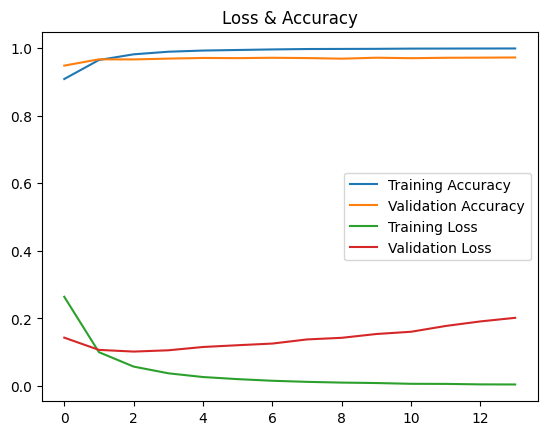

In [ ]:
import matplotlib.pyplot as plt

tokenizer = create_tokenizer(train_docs)
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode= 'binary' )
Xtest = tokenizer.texts_to_matrix(test_docs, mode= 'binary' )
# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)
y = [0.60, 0.70, 0.80, 0.90, 0.100]
plt.title('Loss & Accuracy')
default_y_ticks = range(len(y))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

y = [0.60, 0.70, 0.80, 0.90, 0.100]
default_y_ticks = range(len(y))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
# fit network
# model.fit(Xtrain, ytrain, epochs=14, verbose=2)

In [ ]:
#Negative text
line1 = 'AAPL fails to reach target price. The stock may drop to lowest level and not recover until the end of the bear market'
percent, sentiment = predict_sentiment(line1, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (line1, sentiment, percent*100))

Review: [AAPL fails to reach target price. The stock may drop to lowest level and not recover until the end of the bear market]
Sentiment: POSITIVE (75.060%)


In [ ]:
#Positive text
line2 = 'MSFT increases stock price from 130.12 to 134.12. A 12 percent increase. Under new leadership, Microsoft will be able to reach new highs and highlight good times ahead for shareholders.'
percent, sentiment = predict_sentiment(line2, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (line2, sentiment, percent*100))

Review: [MSFT increases stock price from 130.12 to 134.12. A 12 percent increase. Under new leadership, Microsoft will be able to reach new highs and highlight good times ahead for shareholders.]
Sentiment: POSITIVE (64.860%)


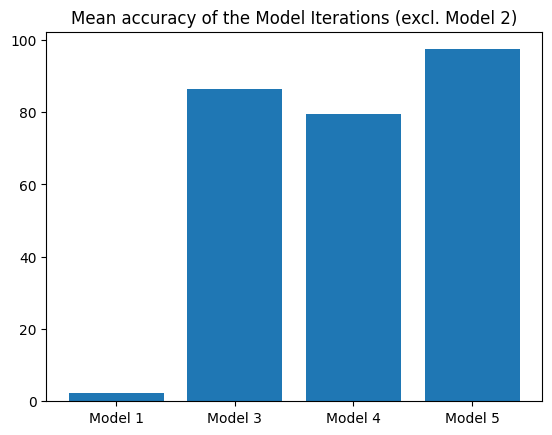

In [ ]:
import matplotlib.pyplot as plt

Accuracy = [2.3265, 86.43, 79.47, 97.37]
Methods = ['Model 1', 'Model 3', 'Model 4', 'Model 5']
Accuracy_pos = np.arange(len(Methods))

plt.bar(Accuracy_pos, Accuracy)
plt.xticks(Accuracy_pos, Methods)
plt.title('Mean accuracy of the Model Iterations (excl. Model 2)')
plt.show()

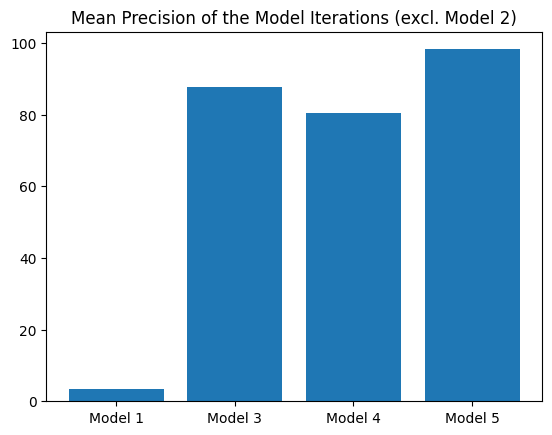

In [ ]:
import matplotlib.pyplot as plt

Precision = [3.41, 87.79, 80.31, 98.21]
Methods2 = ['Model 1', 'Model 3', 'Model 4', 'Model 5']
Precision_pos = np.arange(len(Methods2))

plt.bar(Precision_pos, Precision)
plt.xticks(Precision_pos, Methods2)
plt.title('Mean Precision of the Model Iterations (excl. Model 2)')
plt.show()

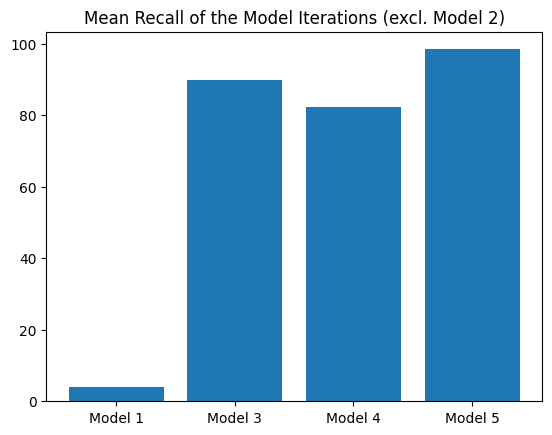

In [ ]:
import matplotlib.pyplot as plt

Recall = [3.97, 89.73, 82.31, 98.40]
Methods3 = ['Model 1', 'Model 3', 'Model 4', 'Model 5']
Recall_pos = np.arange(len(Methods3))

plt.bar(Recall_pos, Recall)
plt.xticks(Recall_pos, Methods2)
plt.title('Mean Recall of the Model Iterations (excl. Model 2)')
plt.show()